### import toolkit

In [1]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

### convolution helper functions

In [2]:
def get_kernel_type(kernel):
    # Assumption: kernel shape (hw, kw) => 1d or 2d (single channel)
    hk, wk = kernel.shape
    kernel_type=None

    if hk==1:
        kernel_type='1d-horizontal'
    elif wk==1:
        kernel_type='1d-vertical'
    else:
        kernel_type='2d'

    return kernel_type

In [3]:
def get_pads(kernel_type, pad):
    # Assumption pad is integer val or (ph, pw) type tuple for 2d conv
    pad_h = None
    pad_w = None

    if kernel_type=='1d-horizontal':
        if type(pad)==int:
            pad_h = 0
            pad_w = pad

    elif kernel_type=='1d-vertical':
        if type(pad)==int:
            pad_h = pad
            pad_w = 0

    elif kernel_type=='2d':
        if type(pad)==int:
            pad_h = pad
            pad_w = pad
        elif type(pad)==tuple and len(pad)==2:
            pad_h, pad_w = pad

    return pad_h, pad_w


def pad_image(image, pads):
    hi, wi = image.shape
    pad_h, pad_w = pads

    padded_image_shape = (hi+2*pad_h, wi+2*pad_w)
    padded_image = np.zeros(padded_image_shape)
    padded_image[pad_h:pad_h+hi, pad_w:pad_w+wi] = image

    return padded_image

In [4]:
def get_strides(kernel_type, stride):
    # Assumption stride is integer val or (sh, sw) type tuple for 2d conv
    stride_h = None
    stride_w = None

    if kernel_type=='1d-horizontal':
        if type(stride)==int:
            stride_h = 1
            stride_w = stride

    elif kernel_type=='1d-vertical':
        if type(stride)==int:
            stride_h = stride
            stride_w = 1

    elif kernel_type=='2d':
        if type(stride)==int:
            stride_h = stride
            stride_w = stride
        elif type(stride)==tuple and len(stride)==2:
            stride_h, stride_w = stride

    return stride_h, stride_w


def apply_conv(padded_image, kernel, strides):
    hk, wk = kernel.shape
    stride_h, stride_w = strides
    output = []

    for i in range(0, padded_image.shape[0]-hk+1, stride_h):
        out = []
        for j in range(0, padded_image.shape[1]-wk+1, stride_w):
            filter_shaped_slice = padded_image[i:i+hk, j:j+wk]
            val = np.sum(filter_shaped_slice * kernel)
            out.append(val)
        output.append(out)

    output = np.array(output)
    return output

In [5]:
def conv(image, kernel, pad=0, stride=1):
    kernel_type = get_kernel_type(kernel)

    pads = get_pads(kernel_type, pad)
    padded_image = pad_image(image, pads)

    strides = get_strides(kernel_type, stride)
    output = apply_conv(padded_image, kernel, strides)

    return output

### Read sample image

In [6]:
DATASET_DIR_PATH = "Assignment 1 Input Images\Question 1"
SAMPLE_IMAGE_RELATIVE_PATH = "2.jpeg"

In [7]:
sample_image_path = os.path.join(DATASET_DIR_PATH, SAMPLE_IMAGE_RELATIVE_PATH)
image = mpimg.imread(sample_image_path)
print(type(image))

<class 'numpy.ndarray'>


In [8]:
print(image.shape)

(333, 500, 3)


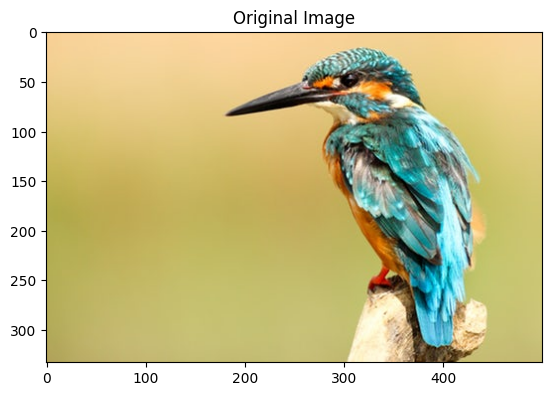

In [9]:
plt.imshow(image)
plt.title("Original Image")
plt.show()

# 1. Convert image to grayscale
* Grayscale is single channel scale which contains only intensity information.
* Harris corner detection only requires Intensity information.

* Issues with RGB:
    * Since, RGB channels contains color intensities. This additional information is irrelevant.
    * and might add color sensitivity to the algorithm making it inaccurate.
    * Since, grayscale is color-invariant, therefore it is more robust.
    * Also, rgb channels will require equal computations per channel which implies more complexity for algorithm.

In [10]:
"""
grayscale pixel is weighted sum of R,G,B pixels
Grayscale_pixel = w_R * c_R + w_G * c_G + w_B * c_B

https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html
OpenCV's conversion formula:
RGB[A] to Gray : Y ← 0.299*R + 0.587*G + 0.114*B
"""

def to_grayscale(image):
    # ASSUMPTION: input image format is RGB[A] or grayscale

    # if image.shape shape tuple has 3rd value
    # then it has more than 1 channel
    image_channels = 1
    if len(image.shape) > 2:
        image_channels = image.shape[2]

    # single channel implies already grayscaled image
    if image_channels==1:
        # convert image shape from (h, w, 1) to (h, w)
        if len(image.shape) > 2:
            image = np.squeeze(image, axis=-1)
        return image

    # 4 channels imply alpha channel, so we can ignore it
    if image_channels==4:
        image = image[:, :, :-1]
        image_channels -= 1

    # now we are left with RGB image
    RGB_weights = np.array([[0.299], [0.587], [0.114]])
    gray_image = image @ RGB_weights
    return np.squeeze(gray_image, axis=-1)

(333, 500)


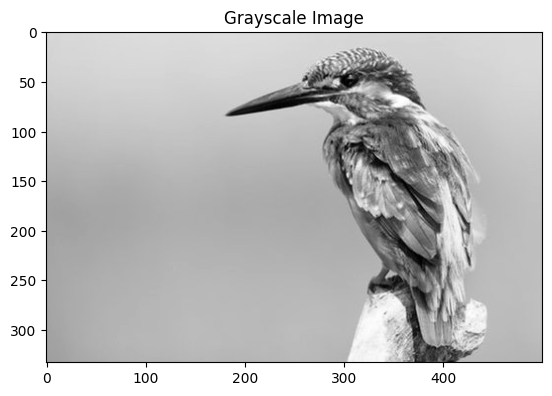

In [11]:
gray_image = to_grayscale(image)
print(gray_image.shape)
plt.imshow(gray_image, cmap='gray')
plt.title("Grayscale Image")
plt.show()

# 2. Intensity Partial Derivative Calculation
* x gradient filter = [-1, 0, 1]
* y gradient filter is transpose of x gradient filter
* convolution of image with respective filters gives gradients along respective axis.

In [12]:
def image_partial_derivatives(image):
    y_gradient_filter = np.array([[-1], [0], [1]])
    x_gradient_filter = y_gradient_filter.T

    image_x_derivative = conv(image, x_gradient_filter, pad=1, stride=1)
    image_y_derivative = conv(image, y_gradient_filter, pad=1, stride=1)

    return image_x_derivative, image_y_derivative

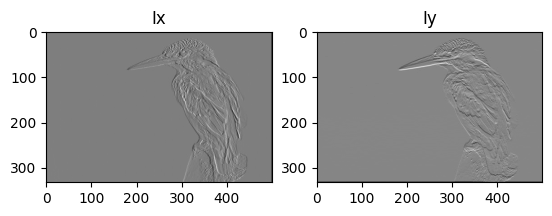

In [30]:
Ix, Iy = image_partial_derivatives(gray_image)

fig, ax = plt.subplots(1, 2)
# fig.suptitle("Image Partial Derivatives")
ax[0].set_title("Ix")
ax[0].imshow(Ix, cmap='gray')
ax[1].set_title("Iy")
ax[1].imshow(Iy, cmap='gray')
plt.show()

# 3. harris corner detection

In [14]:
def get_harris_response_matrix(Ix, Iy, num_patch_neighbours, k=0.04):
    # element-wise multiplication of Ix and Iy
    Ixx = np.square(Ix)
    Iyy = np.square(Iy)
    Ixy = Ix * Iy

    # sum kernel's convolution sums all values overlapping with kernel
    u, v = num_patch_neighbours
    sum_kernel = np.ones((2*u + 1, 2*v + 1))
    same_pad = ((sum_kernel.shape[0]-1)//2, (sum_kernel.shape[1]-1)//2)

    # sum of square intensity gradients for defining structure matrix
    Sxx = conv(Ixx, sum_kernel, pad=same_pad, stride=1)
    Sxy = conv(Ixy, sum_kernel, pad=same_pad, stride=1)
    Syy = conv(Iyy, sum_kernel, pad=same_pad, stride=1)

    # M = [
    #     [Sxx, Sxy],
    #     [Sxy, Syy]
    # ]
    # response = determinant(M) - k * trace(M)
    response = (Sxx * Syy - np.square(Sxy)) - k * np.square(Sxx + Syy)
    return response

In [15]:
NUM_PATCH_NEIGHBOURS_HARRIS = (1, 1)
K = 0.04
response = get_harris_response_matrix(Ix, Iy, NUM_PATCH_NEIGHBOURS_HARRIS, K)

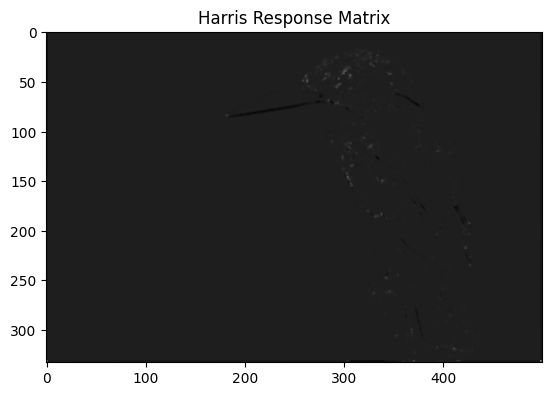

In [31]:
plt.imshow(response, cmap='gray')
plt.title("Harris Response Matrix")
plt.show()

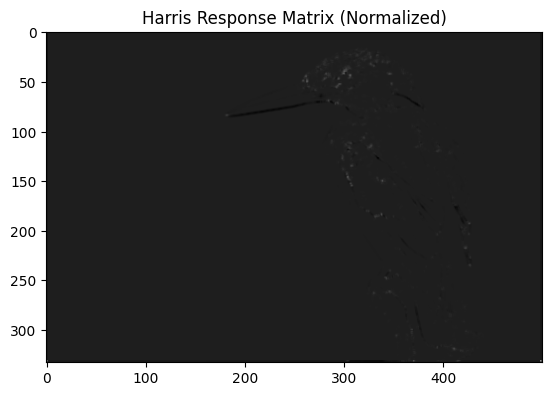

In [32]:
min_max_norm_response = (response - response.min()) / (response.max() - response.min())
plt.imshow(min_max_norm_response, cmap='gray')
plt.title("Harris Response Matrix (Normalized)")
plt.show()

In [18]:
min_max_norm_response.max(), min_max_norm_response.min()

(1.0, 0.0)

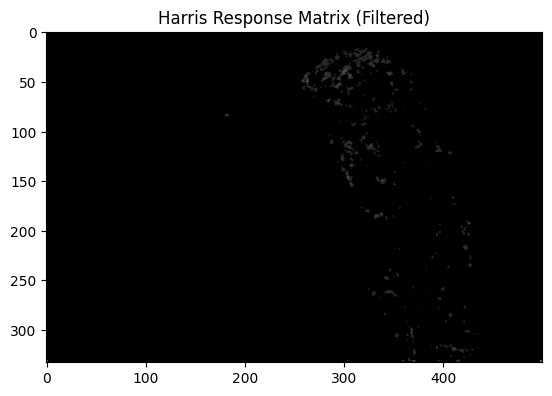

In [33]:
THRESHOLD = 0.13
filtered_response = min_max_norm_response * (min_max_norm_response > THRESHOLD)

plt.imshow(filtered_response, cmap='gray')
plt.title("Harris Response Matrix (Filtered)")
plt.show()

In [20]:
def non_max_suppression(filtered_response_matrix, num_patch_neighbours):
    # get coords of corners filtered by harris response and threshold
    x_cords, y_cords = np.nonzero(filtered_response_matrix)
    proposed_corners = [[filtered_response[x, y], x, y, False] for x, y in zip(x_cords, y_cords)]

    # window for considering non-max-suppression is 2*p+1, 2*q+1
    p, q = num_patch_neighbours
    # sort all corners based on decreasing response value
    sorted_proposed_corners = sorted(proposed_corners, reverse=True)

    # take strongest corner
    for i in range(len(sorted_proposed_corners)):
        stronger_corner = sorted_proposed_corners[i]
        if stronger_corner[3]==True:
            continue

        # take weaker corner
        for j in range(i+1, len(sorted_proposed_corners)):
            weaker_corner = sorted_proposed_corners[j]
            if weaker_corner[3]==True:
                continue

            # if weaker corner is in neighbourhood window of stronger corner
            # then remove it
            if abs(weaker_corner[1] - stronger_corner[1]) <= p and abs(weaker_corner[2] - stronger_corner[2]) <= q:
                sorted_proposed_corners[j][3] = True

    # overlay is binary valued image to show all corners
    non_max_suppression_overlay = np.zeros(filtered_response_matrix.shape)
    non_max_suppression_corners = [(x, y) for _, x, y, s in sorted_proposed_corners if s==False]

    for x, y in non_max_suppression_corners:
        non_max_suppression_overlay[x, y] = 1

    return non_max_suppression_overlay, non_max_suppression_corners

In [21]:
NUM_PATCH_NEIGHBOURS_NMS = (2, 2)
non_max_suppression_overlay, non_max_suppression_corners = non_max_suppression(filtered_response, NUM_PATCH_NEIGHBOURS_NMS)

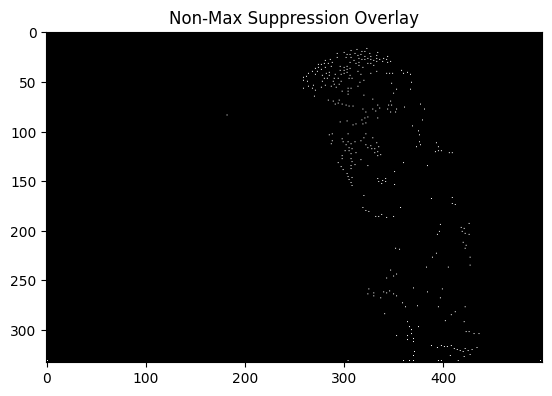

In [34]:
plt.imshow(non_max_suppression_overlay, cmap='gray')
plt.title("Non-Max Suppression Overlay")
plt.show()

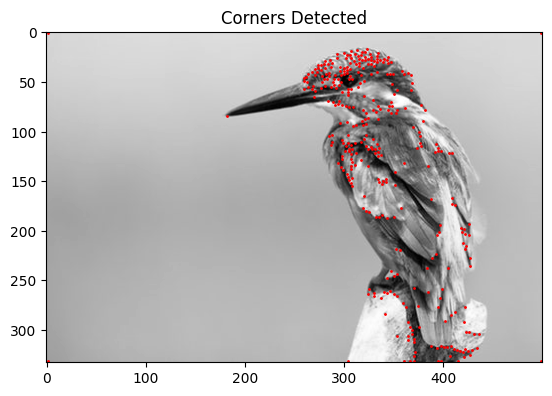

In [35]:
# plt.imshow(1*non_max_suppression_overlay + 0.002 * gray_image, cmap='gray')
plt.imshow(gray_image, cmap='gray')
for x, y in non_max_suppression_corners:
    plt.plot(y, x, 'ro', markersize=1)
plt.title("Corners Detected")
plt.show()

In [24]:
non_max_suppression_overlay.shape

(333, 500)

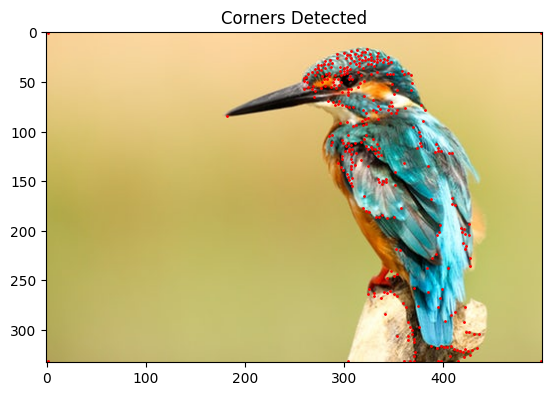

In [36]:
# plot all corners on original image
plt.imshow(image)
for x, y in non_max_suppression_corners:
    plt.plot(y, x, 'ro', markersize=1)
plt.title("Corners Detected")
plt.show()

## comparison to opencv


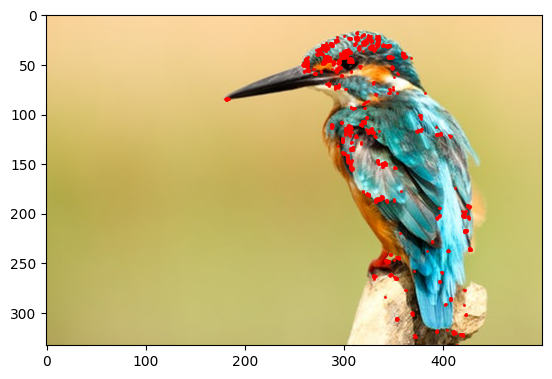

In [26]:
dst = cv2.cornerHarris(np.float32(gray_image), 2*NUM_PATCH_NEIGHBOURS_HARRIS[0]+1, 3, K)

dst = (dst - dst.min()) / (dst.max() - dst.min())
dst = dst * (dst > 0.39)

# plot all corners on original image
plt.imshow(image)
x_cords, y_cords = np.nonzero(dst)
for x, y in zip(x_cords, y_cords):
    plt.plot(y, x, 'ro', markersize=1)
plt.show()